## OCNT-VAMPLIB-1 Mini Assay Run #1: Chunks 3, 10, 14, 15

For the first mini-VAMP-seq experiment, we have 16 samples with the following structure:

| ID | Bins | Barcodes Per Variant | Cells Per Barcode |
| --- | ----------- | --- | --- |
| A | 25, 50, 75, 100 | 15 | 15 | 
| B | 25, 50, 75, 100 |15 | 15 | 
| C | 25, 50, 75, 100 | 30 | 15 |
| D | 25, 50, 75, 100 | 15 | 30 |

A and B are replicates of each other, while C and D are one replicate each of two different experimental procedures. All samples use the same library, OCNT-VAMPLIB-1, and there are not yet distinct "conditions" such as drug treatments to consider. Each of four samples (A - D) was sorted into four approximately equal bins, typically denoted as 25 through 100.

1. [Barcode Sequencing Distributions](#part1)
2. [Inference and Stop Codon Effects](#part2)
3. [Visualizations](#part3)
4. [Condition Comparions](#part4)
5. [Effect of Barcode Map Reduction](#part5)

In [5]:
library(magrittr)
library(data.table)
library(ggpubr)
library(vroom)
library(scales)
library(GGally)
library(ggbeeswarm)
library(scico)
library(ggridges)
library(knitr)
library(fs)
library(broom)
library(broom.mixed)
library(patchwork)
library(ggnewscale)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

### Barcode Sequencing Distributions <a name="part1"></a>

The plots below show the number of unique barcodes per variant in each sample on a linear (left) and log10 (right) scale. The red lines indicate 15 and 30 barcodes per variant, and samples are either separated by bin (top) or shown in aggregate (bottom). To compute the aggregate distributions, we used the union of all barcodes detected across all four bins for the given sample.

In [11]:
mapped_counts <- vroom("../pipeline/OCNT-VAMPLIB-1-assay-run1/tyk2-vamp-mini-form.mapped-counts.tsv",
                          col_names = c("sample", "barcode",  "count", "lib", "chunk", 
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon",
                                        "dox", "chunkID", "condition", "condition_conc","clone"))  %>%
    mutate(condition = as.factor(paste0(condition, condition_conc)),
           mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT")) %>%
    group_by(sample) %>%
    mutate(stop_counts = sum(count[which(mut_aa == "*")]))

Rows: 1636612 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, condition
dbl (4): count, chunk, pos, condition_conc
lgl (3): dox, chunkID, clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


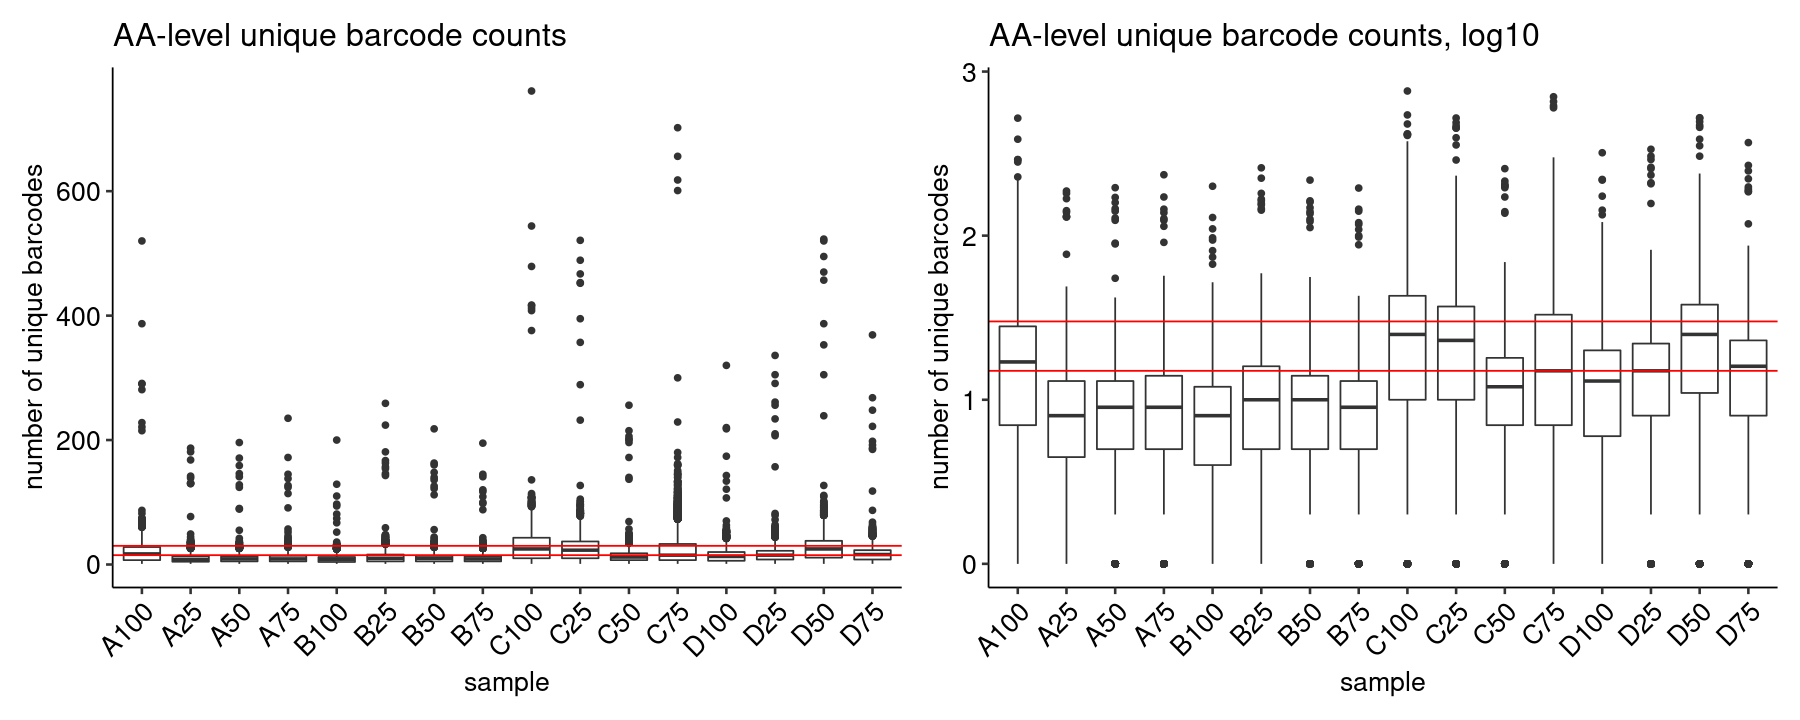

In [6]:
bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_aa,mut_aa,pos, chunk) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        geom_hline(yintercept = c(15, 30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        geom_hline(yintercept = log10(c(15, 30)), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

options(repr.plot.width = 15, repr.plot.height = 6)
res_count + res_count_log

In [61]:
bc_counts_aa %>% ungroup() %>% group_by(sample, chunk) %>% summarize(median(n))

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


sample,chunk,median(n)
<chr>,<dbl>,<dbl>
A,3,17.0
A,10,36.0
A,14,43.0
B,3,15.0
B,10,22.0
B,14,25.0
C,3,29.0
C,10,98.0
C,14,75.0


In [ ]:
mapped_counts %>%

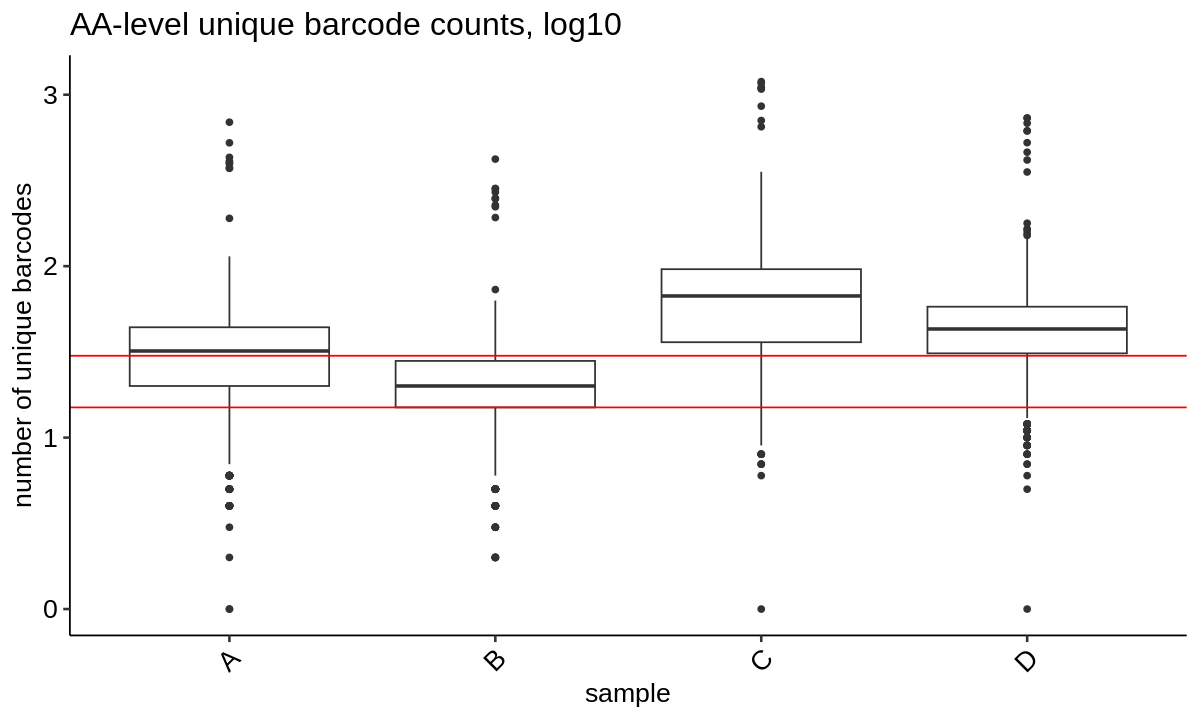

In [60]:
bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT", chunk != 15) %>%
    mutate(sample = str_sub(sample, start = 1, end = 1)) %>%
    select(sample, wt_aa, mut_aa, pos, barcode, chunk) %>%
    distinct() %>%
    group_by(sample,wt_aa,mut_aa,pos, chunk) %>%
    count()

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        geom_hline(yintercept = log10(c(15, 30)), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

options(repr.plot.width = 10, repr.plot.height = 6)
res_count_log

Counting the number of unique barcodes per chunk in each sample shows the expected depletion of chunk 15 relative to the others, and shows that samples C and D generally have more quantified barcodes as expected (with the exception of sample A, bin 100).

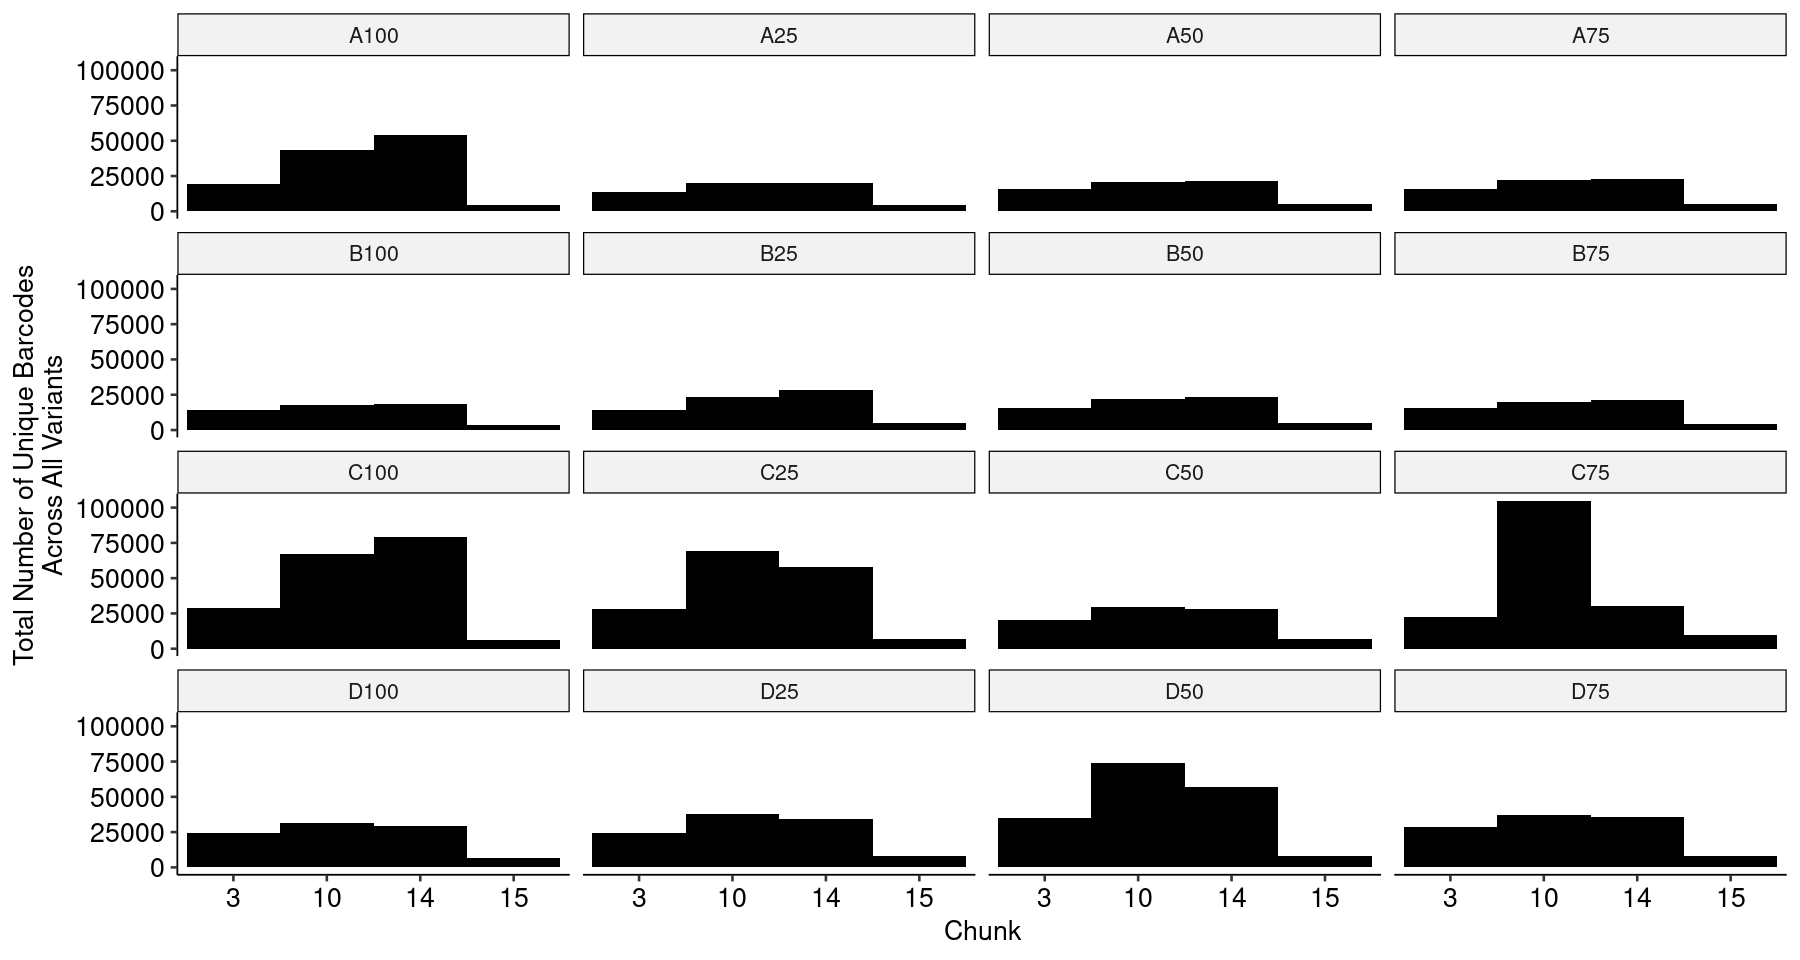

In [7]:
options(repr.plot.width = 15, repr.plot.height = 8)
mapped_counts %>%
    ungroup() %>%
    count(sample, chunk) %>%
    mutate(chunk = as.factor(chunk)) %>%
    ggplot() +
        geom_bar(aes(x = chunk, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_pubr(base_size = 16) +
        facet_wrap(~sample, ncol = 4) +
        xlab("Chunk") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

As before, we can plot the individual amino acid coverage per position, generating a large facet plot for each sample. One of these is shown below, and the rest are located [here](./coverage-plots).

In [11]:
plot_coverage <- function(bcs, sample_id) {
    
    wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")
    
    bcs_subset <- bcs %>%
        filter(sample == sample_id)
    
    allpos <- expand_grid("pos" = 1:1188,
                     "mut_aa" = unique(bcs$mut_aa)) %>%
        filter(!paste0(pos, mut_aa) %in% paste0(wt_aa$pos, wt_aa$wt_aa))

    bcs_subset_expanded <- allpos %>%
        left_join(bcs_subset) %>%
        mutate(n = ifelse(is.na(n), 0, n))
    
    the_plot <- ggplot(bcs_subset_expanded) +
        geom_line(aes(x = as.numeric(pos), y = log10(n))) +
        theme_bw(base_size = 16) +
        ggtitle(paste0("Sample ", sample_id)) +
        facet_wrap(~mut_aa, ncol = 1) +
        xlab("TYK2 position") + ylab("log10(number of unique barcodes)")
    
    ggsave(paste0("coverage-plots/OCNT-VAMPLIB-1-assay-run1-sample", sample_id, ".pdf"),
           the_plot, width = 10, height = 20)
    
    return(the_plot)
}

In [12]:
coverage_plots <- map(.x = unique(bc_counts_aa$sample), .f = ~plot_coverage(bc_counts_aa, .))

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("pos", "mut_aa")
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("pos", "mut_aa")
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("pos", "mut_

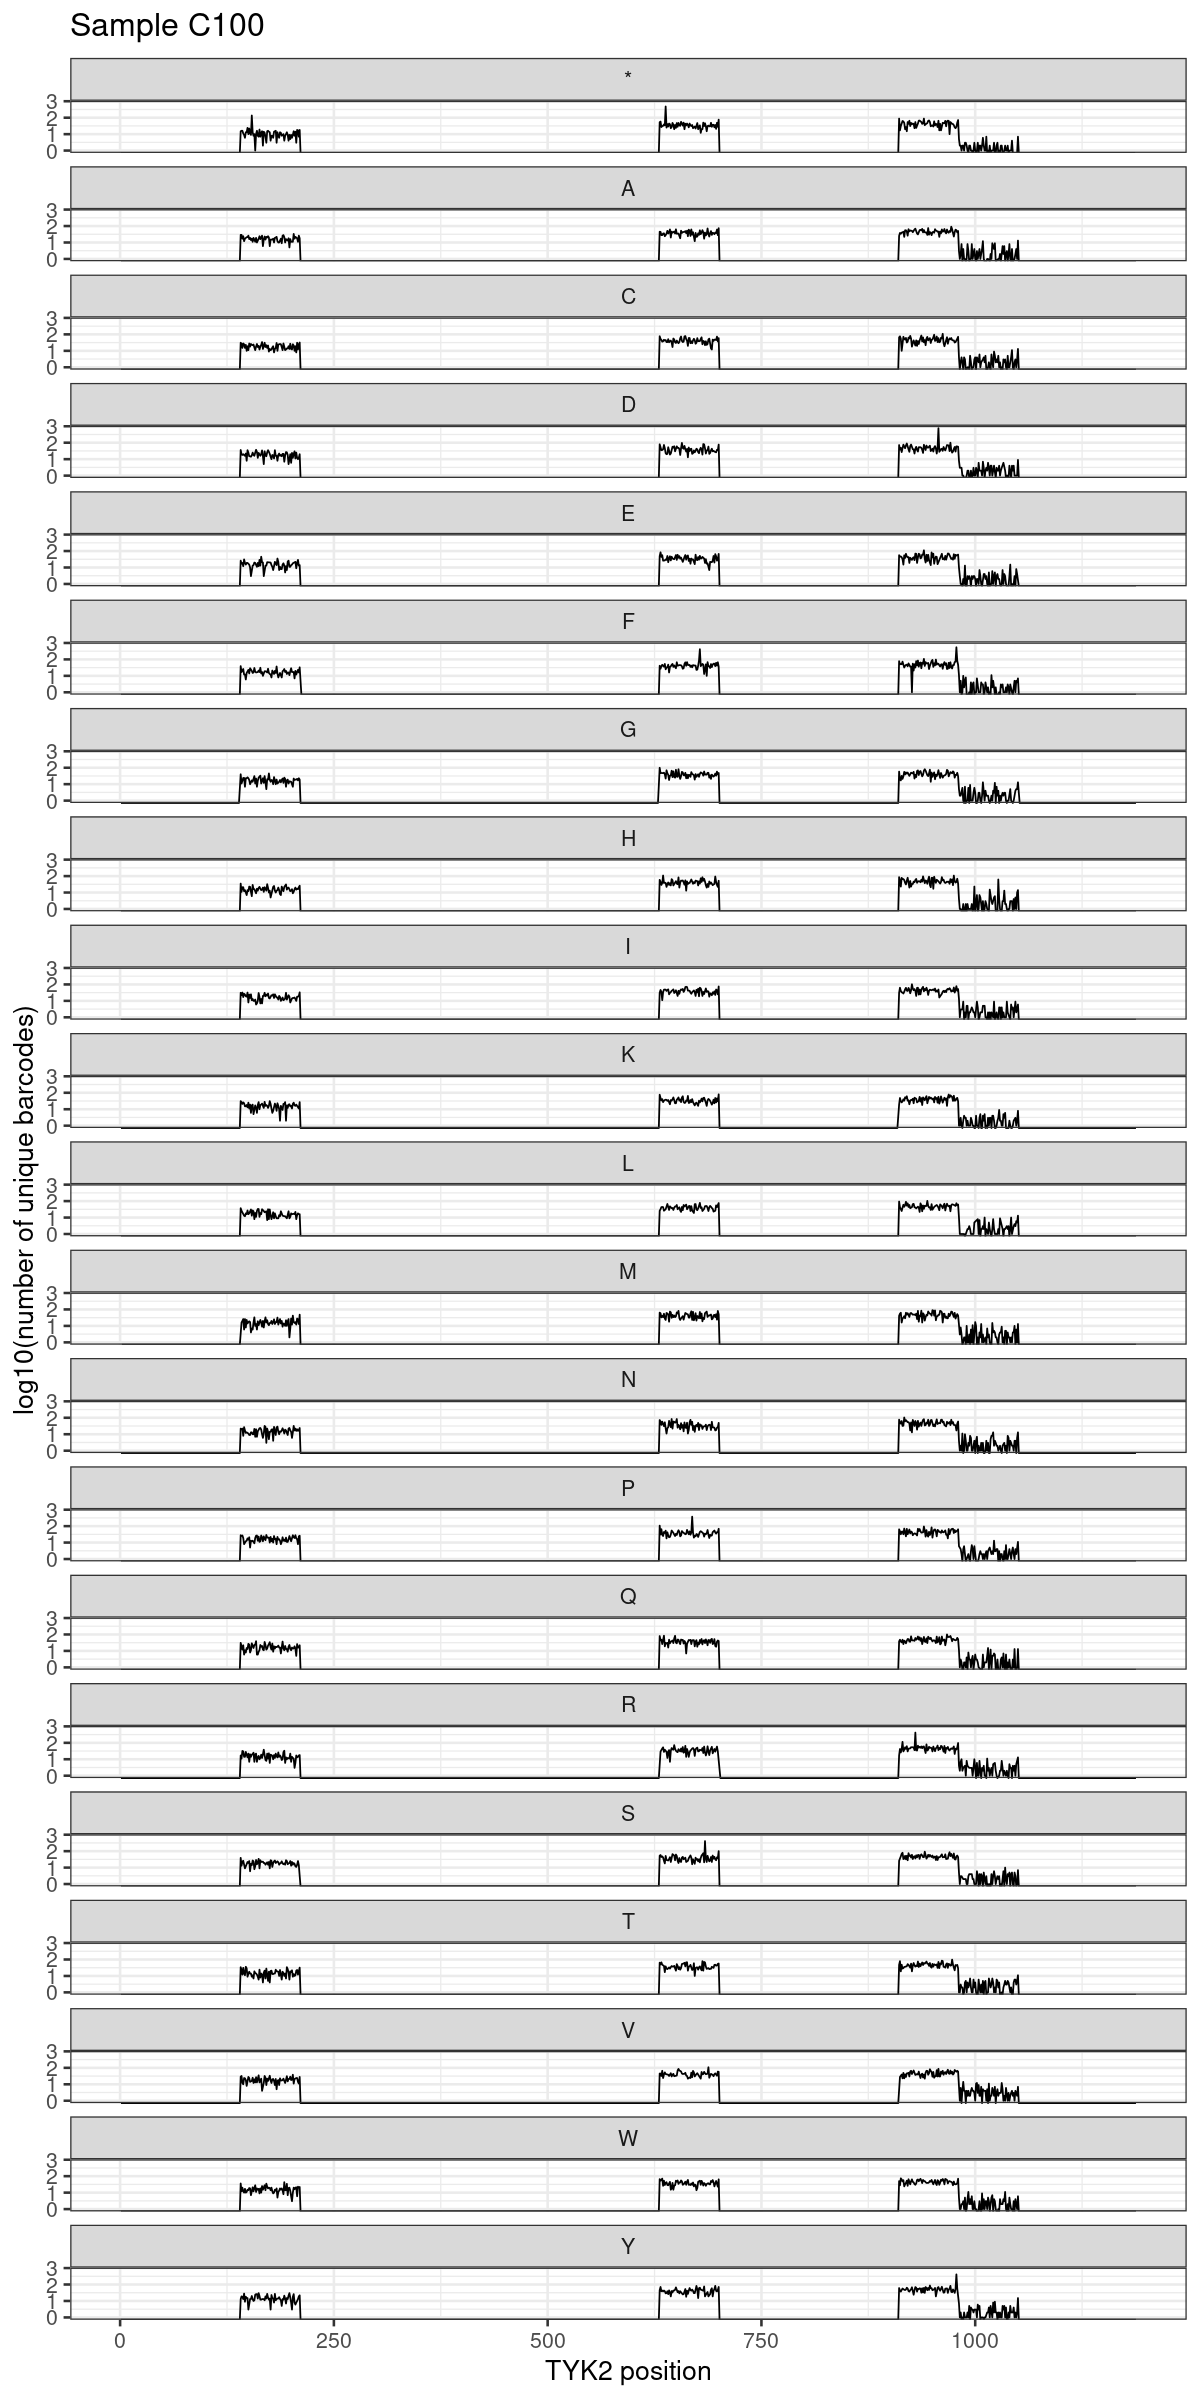

In [13]:
options(repr.plot.width = 10, repr.plot.height = 20)
coverage_plots[[9]]

### Inference and Stop Codon Effects <a name="part2"></a>

We can quantify variant effects in the VAMP-seq context in two ways. First, we can consider each sample and bin (e.g. C75) individually, and estimate the mutant vs wild-type effect. Alternatively, we can consider all four bins for a sample jointly, and model the bin itself as a numerical predictor (e.g. 0/1/2/3).

In the first model, we obtain four summary statistics for each variant (one per bin). In the second model, we obtain only one summary statistic for each variant (the slope of the mutant vs WT effect _across_ bins). Most of the time, the "slope" model is the important result we care about, but the "per-bin" model is useful as well to visualize particular positions in high detail.

To get started we extract and plot Stop effects for each sample group, considering A and B jointly as replicates:

In [14]:
sumstats <- dir_ls(path = "../sumstats/TYK2-VAMP/run1/", regexp = "tyk2-.*vampseq.sumstats.tsv") %>%
    map_dfr(read_tsv, col_types = c("ncccnnnnnc"), .id = "source") %>%
    filter(grepl("condition_conc:mut_aa",term),
           !grepl("15", source)) %>%
    separate(term, c("X", "aa"), ":") %>% 
    mutate(source = gsub("../sumstats/TYK2-VAMP/run1/tyk2-vamp-mini_|-vampseq.sumstats.tsv", "", source),
           estimate = estimate / log(2),
           std.error = std.error / log(2),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa),
           p.adj = p.adjust(p.value, method = "fdr")) %>%
    select(-clone, -dispersion, -version, -X)

wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
sumstats_c <- read_tsv("../sumstats/TYK2-VAMP/run1/tyk2-vampseq-slope.sumstats.tsv") %>%
    filter(grepl("C", source))

sumstats_c_stop_pdf <- sumstats_c %>% 
    ggplot() +
        geom_density(aes(fill = if_else(aa == "*", "Stop", "Non-Stop"), x = statistic),
                     alpha = 0.4) +
        theme_pubr(base_size = 20) +
        geom_hline(yintercept = 0, color = "red") +
        xlab("Slope Z-statistic") + ylab("Z-Statistic") +
        scale_fill_manual(values = c("Stop" = "red", "Non-Stop" = "black")) +
        theme(legend.title = element_blank()) +
        coord_cartesian(xlim = c(-15,5))
ggsave("../dataviz/TYK2/vampseq/TYK2-VAMP-StopZ.pdf",
       sumstats_c_stop_pdf,
       height = 5,
       width = 10)

Rows: 12597 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): source, aa
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


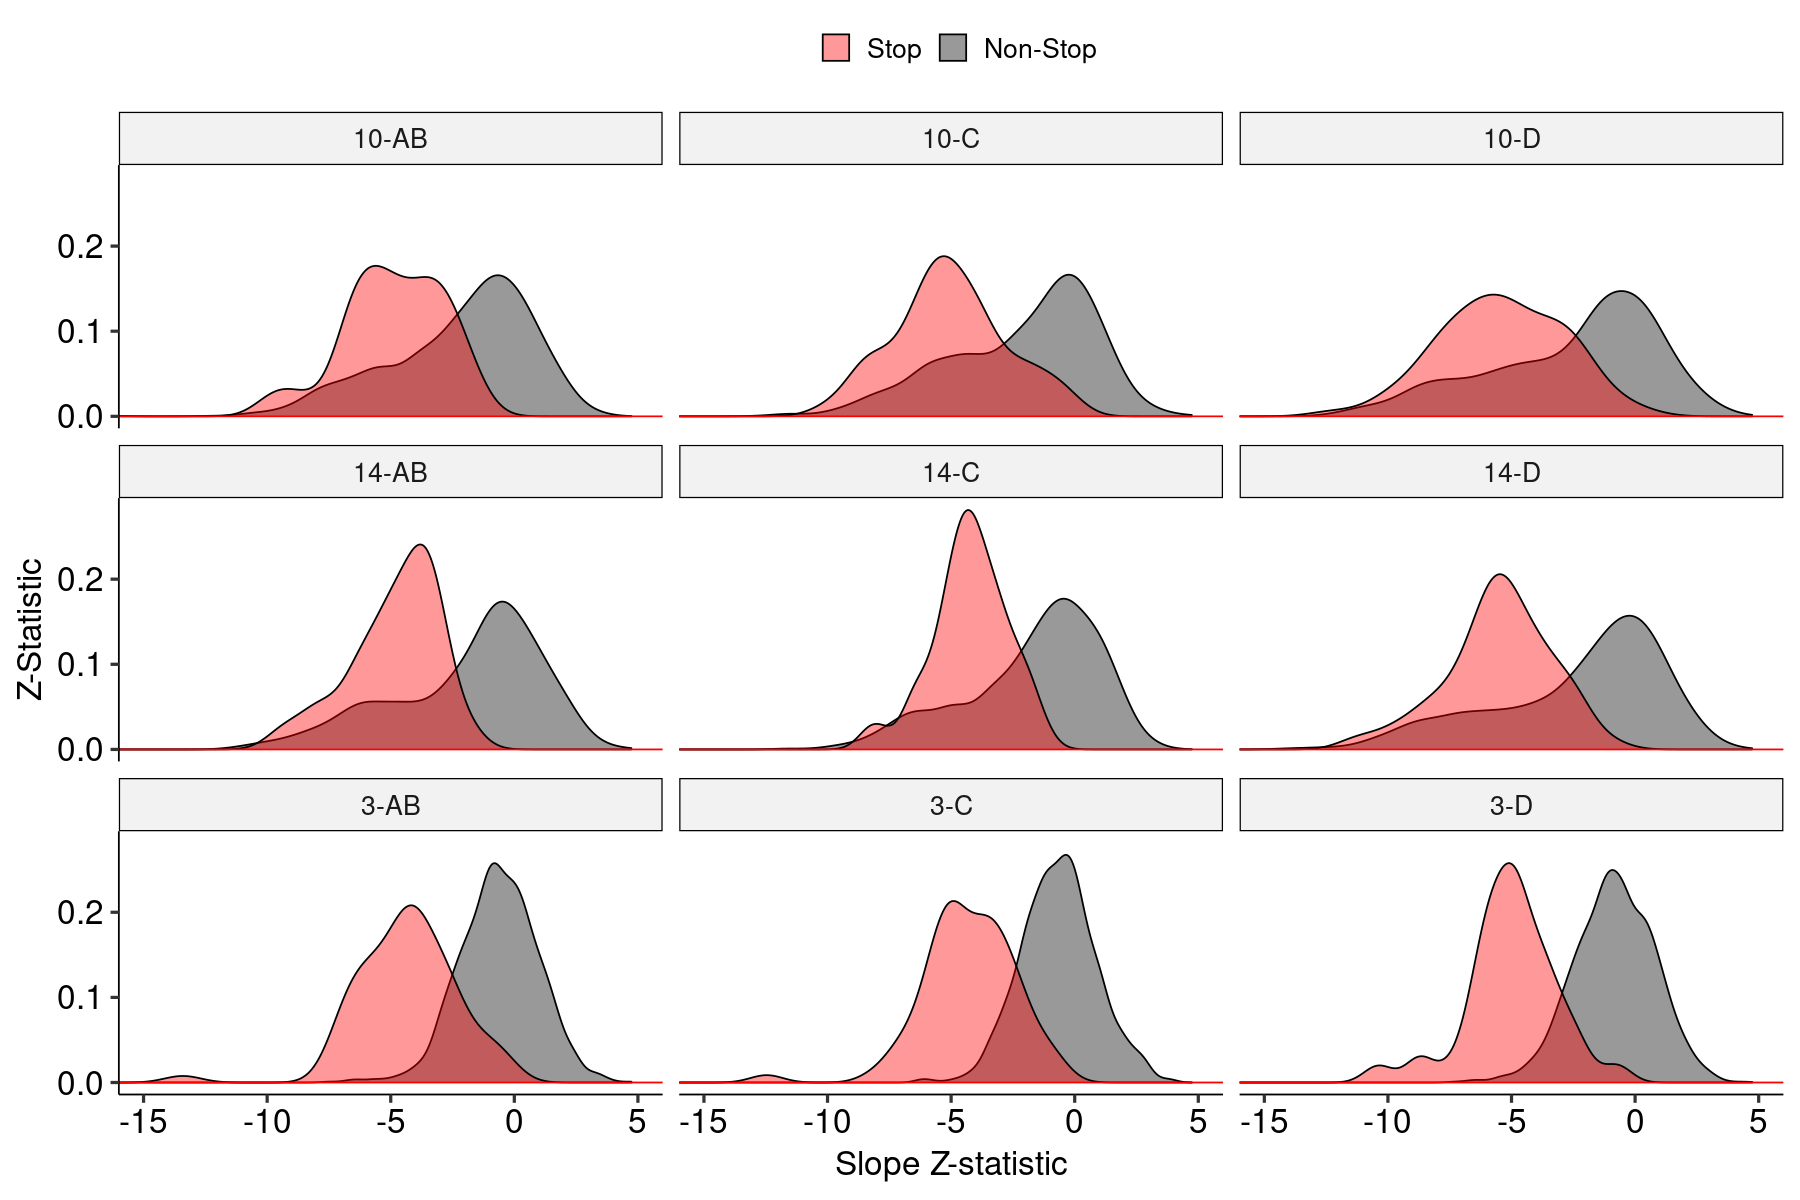

In [36]:
options(repr.plot.width = 15, repr.plot.height = 10)
sumstats %>% 
    ggplot() +
        geom_density(aes(fill = if_else(aa == "*", "Stop", "Non-Stop"), x = statistic),
                     alpha = 0.4) +
        theme_pubr(base_size = 20) +
        geom_hline(yintercept = 0, color = "red") +
        xlab("Slope Z-statistic") + ylab("Z-Statistic") +
        scale_fill_manual(values = c("Stop" = "red", "Non-Stop" = "black")) +
        facet_wrap(~source) +
        theme(legend.title = element_blank()) +
        coord_cartesian(xlim = c(-15,5))

We can also examine directly the number of variants across all comparisons that are significant at a 1% FDR:

In [41]:
sumstats %>%
    count(source,
          class = case_when(p.adj < 0.01 & estimate > 0 ~ "GoF (1% FDR)",
                            p.adj < 0.01 & estimate < 0 ~ "LoF (1% FDR)",
                            TRUE ~ "Non-Significant")) %>%
    pivot_wider(names_from = class, values_from = n, values_fill = 0) %>%
    kable(type = "markdown", digits = 10)



|source | GoF (1% FDR)| LoF (1% FDR)| Non-Significant|
|:------|------------:|------------:|---------------:|
|10-AB  |            6|          492|             902|
|10-C   |           13|          503|             884|
|10-D   |           14|          548|             838|
|14-AB  |           13|          458|             928|
|14-C   |            8|          418|             973|
|14-D   |           11|          500|             888|
|3-AB   |           15|          134|            1251|
|3-C    |            8|          133|            1259|
|3-D    |            7|          178|            1215|

### Visualizations <a name="part3"></a>

As before, we can show the same Log2FoldChanges and Z-statistics as heatmaps:

In [17]:
options(repr.plot.width = 15, repr.plot.height = 12)
sumstats_c_heat_l2fc <- sumstats_c %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Log2FoldChange" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = `Log2FoldChange`)) +
            scale_fill_scico_mid(limits = c(-3,3), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 20, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~source, ncol = 1, scales = "free_x") +
            ggtitle("TYK2 VAMP-Seq")

sumstats_c_heat_z <- sumstats_c %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = `Z-Statistic`)) +
            scale_fill_scico_mid(limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 20, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~source, ncol = 1, scales = "free_x") +
            ggtitle("TYK2 VAMP-Seq")

ggsave("../dataviz/TYK2/vampseq/TYK2-VAMP-L2FC.pdf",
       sumstats_c_heat_l2fc,
       height = 15,
       width = 15)

ggsave("../dataviz/TYK2/vampseq/TYK2-VAMP-Z.pdf",
       sumstats_c_heat_z,
       height = 15,
       width = 15)

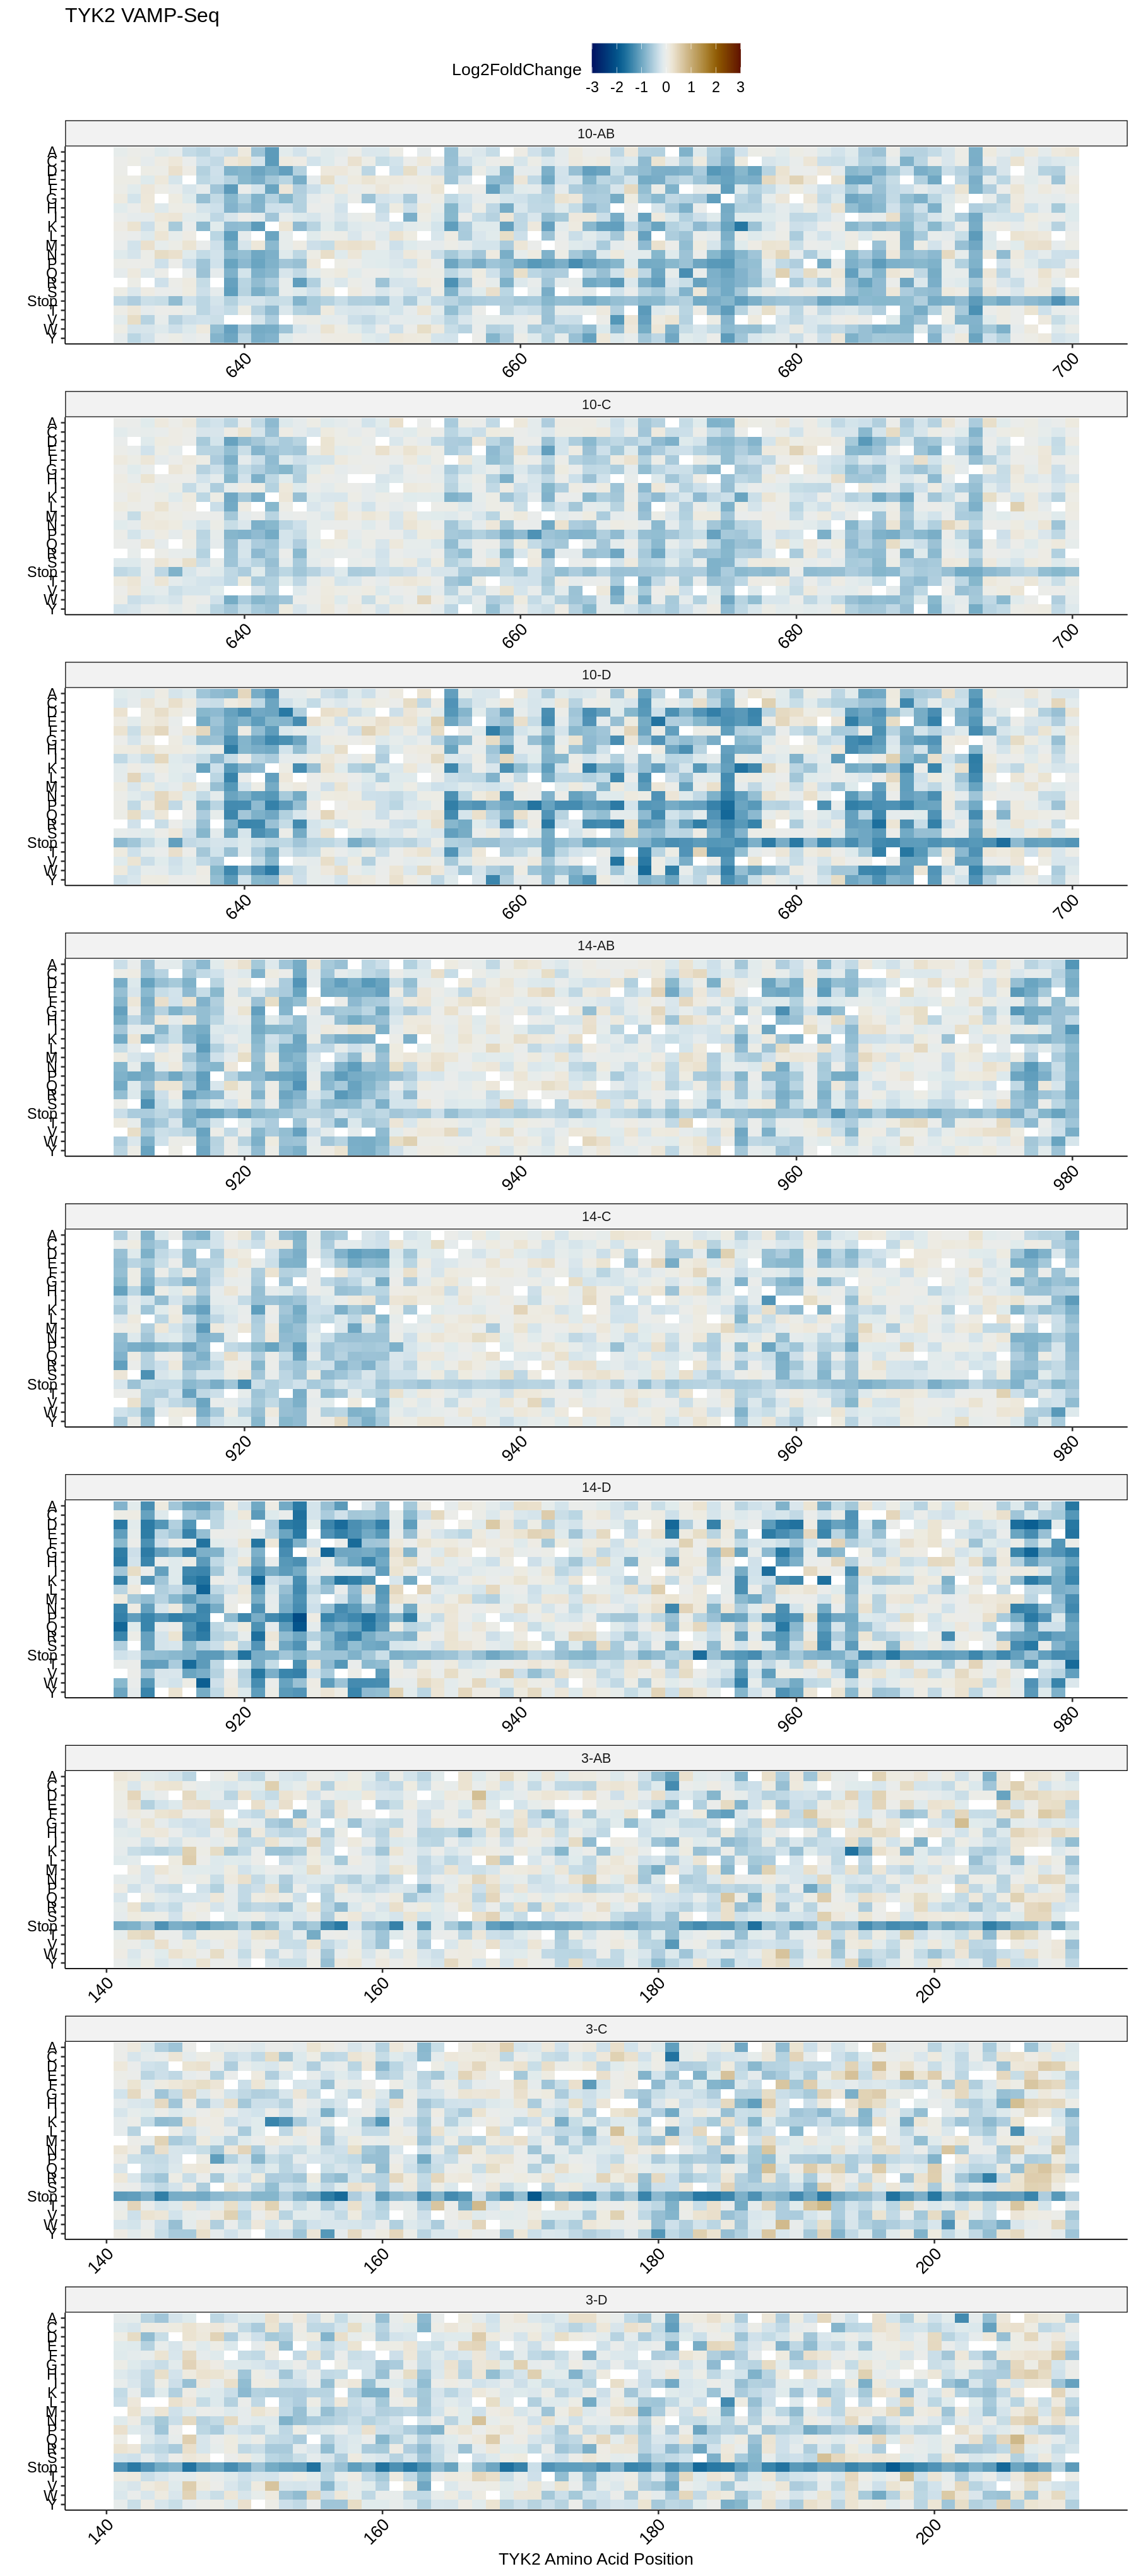

In [20]:
options(repr.plot.width = 15, repr.plot.height = 34)
sumstats %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Log2FoldChange" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = `Log2FoldChange`)) +
            scale_fill_scico_mid(limits = c(-3,3), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~source, ncol = 1, scales = "free_x") +
            ggtitle("TYK2 VAMP-Seq")

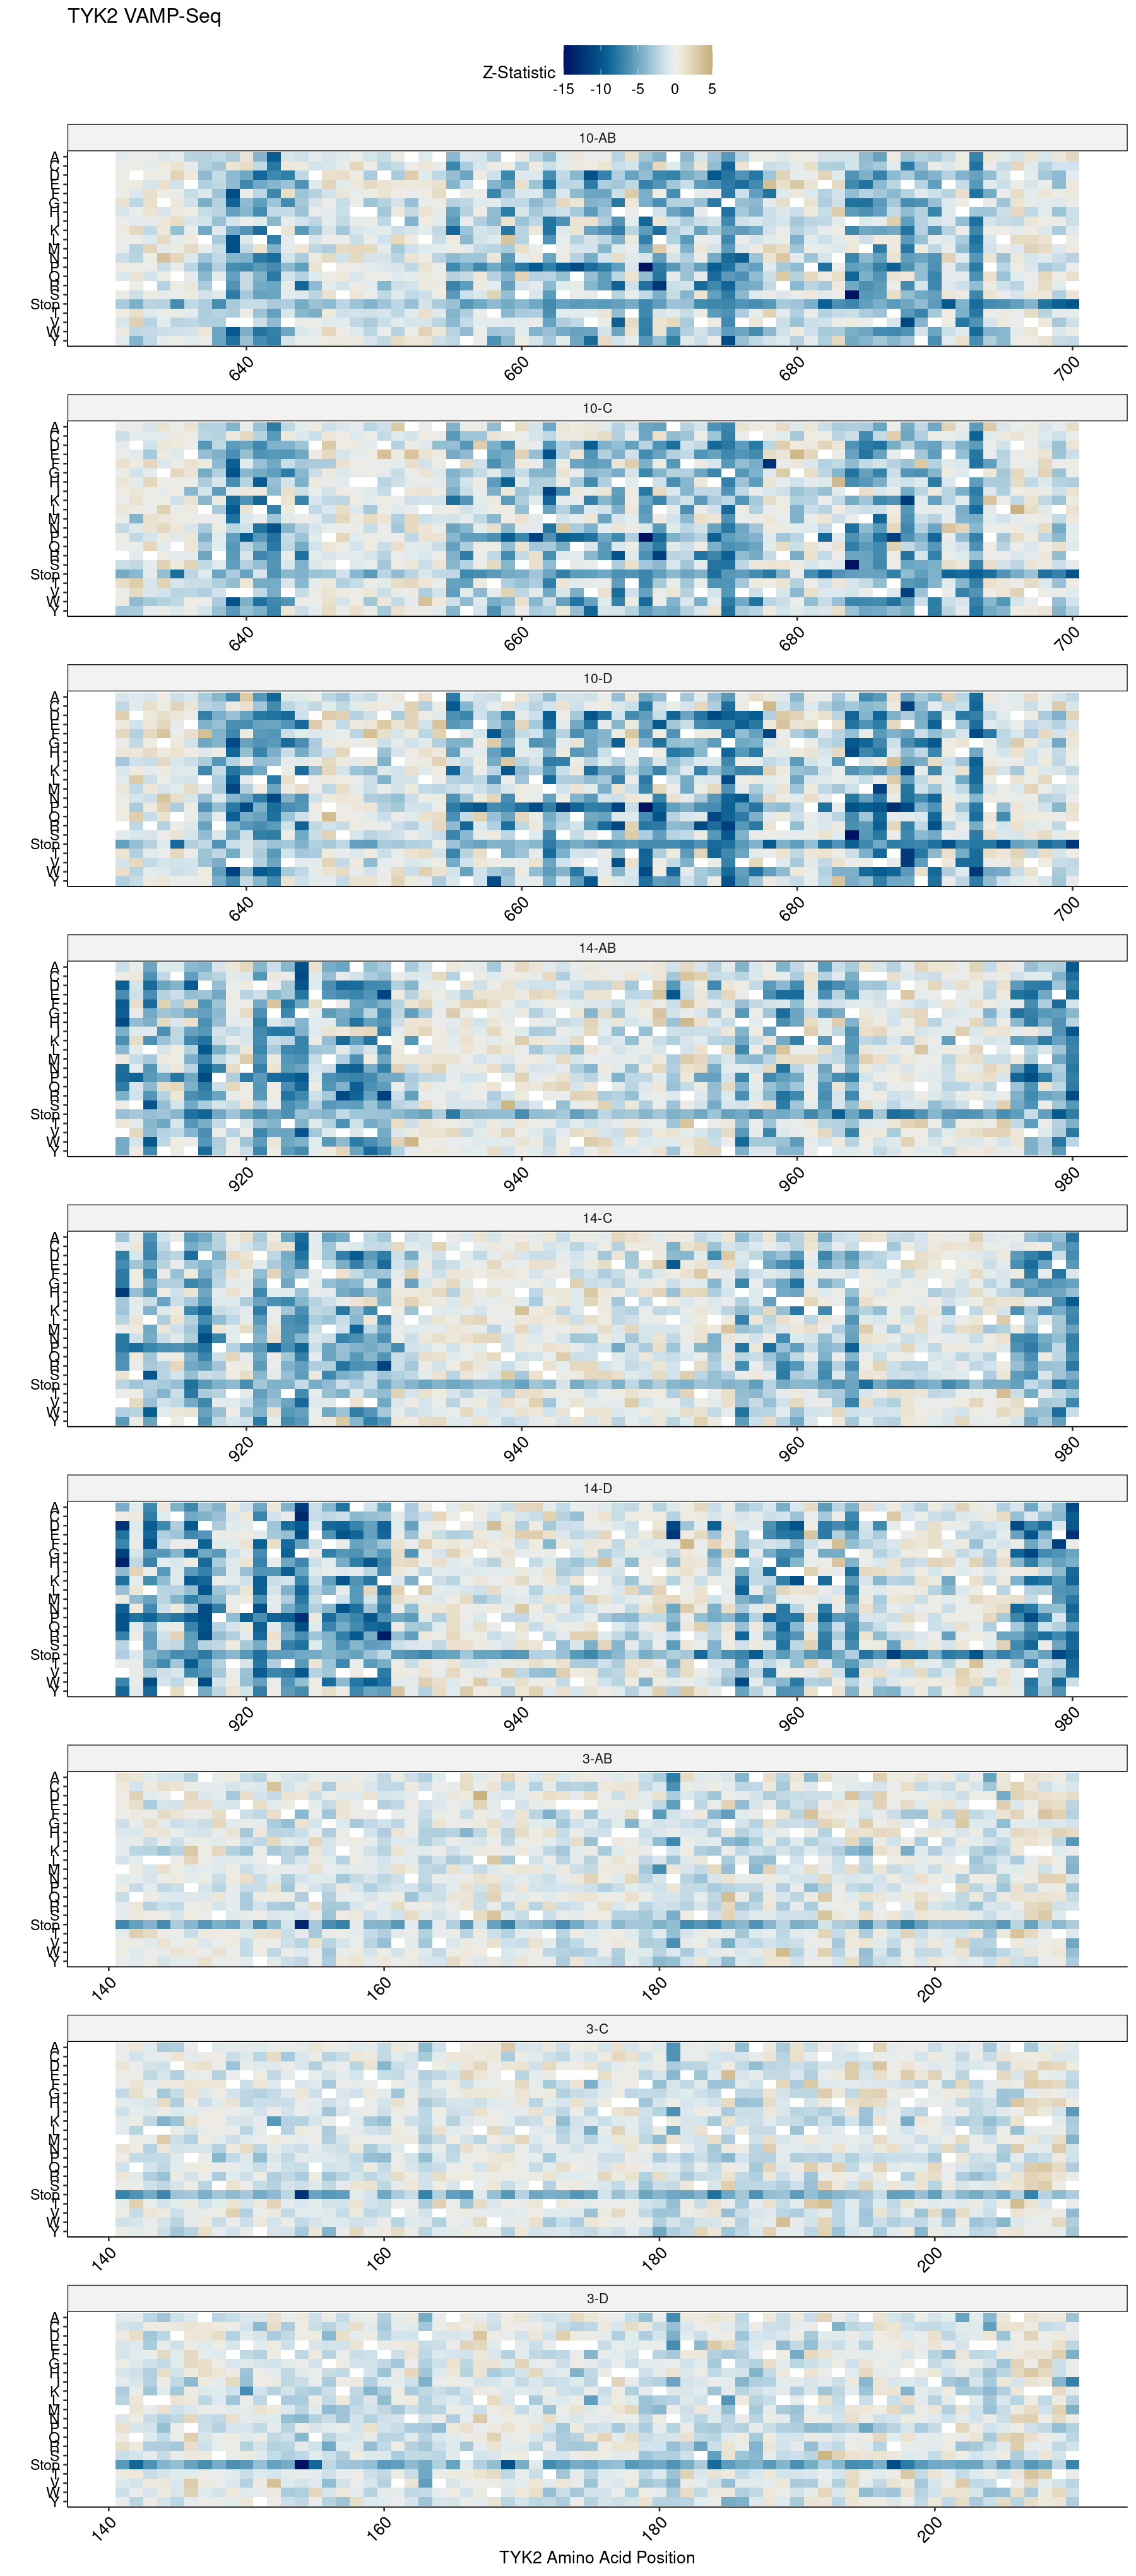

In [76]:
options(repr.plot.width = 15, repr.plot.height = 34)
sumstats %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = `Z-Statistic`)) +
            scale_fill_scico_mid(limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~source, ncol = 1, scales = "free_x") +
            ggtitle("TYK2 VAMP-Seq")

To get a better intuition for what "GoF" and "LoF" mean in the context of slopes across bins, we can extract the most significant GoF and LoF variants across all the plotted variants above, and display their _per-bin_ mutant vs WT summary statistics. First, let's get the top 5 GoF and LoF:

In [4]:
sumstats_bin <- dir_ls(path = "../sumstats/TYK2-VAMP/run1/", regexp = "tyk2-.*combined.sumstats.tsv") %>%
    map_dfr(read_tsv, col_types = c("ncccnnnnnc")) %>%
    filter(grepl("mut_aa",term), pos != 1188) %>%
    separate(term, c("condition", "aa"), ":") %>% 
    mutate(estimate = estimate / log(2),
           std.error = std.error / log(2),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa),
           condition = gsub("condition", "", condition),
           condition = if_else(condition == "D101", "D100", condition),
           sample = str_sub(condition, start = 1, end = 1),
           bin = as.numeric(str_sub(condition, start = 2, end = 4))/25 - 1) %>%
    select(-clone, -dispersion, -version)

wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [55]:
sumstats %>%
    filter(estimate > 0) %>%
    arrange(p.adj) %>%
    head(5) %>%
    kable("markdown")

sumstats %>%
    filter(estimate < 0) %>%
    arrange(p.adj) %>%
    head(5) %>%
    kable("markdown")



|source | pos|chunk |aa |  estimate| std.error| statistic|  p.value|    p.adj|
|:------|---:|:-----|:--|---------:|---------:|---------:|--------:|--------:|
|3-AB   | 167|3     |D  | 0.7564435| 0.1596624|  4.737769| 2.20e-06| 1.34e-05|
|10-C   | 696|10    |L  | 0.5261324| 0.1117830|  4.706729| 2.50e-06| 1.55e-05|
|3-D    | 192|3     |S  | 0.7359611| 0.1664602|  4.421244| 9.80e-06| 5.56e-05|
|14-AB  | 939|14    |S  | 0.4734079| 0.1086648|  4.356589| 1.32e-05| 7.33e-05|
|14-AB  | 932|14    |W  | 0.5186452| 0.1194197|  4.343044| 1.41e-05| 7.76e-05|



|source | pos|chunk |aa |   estimate| std.error| statistic| p.value| p.adj|
|:------|---:|:-----|:--|----------:|---------:|---------:|-------:|-----:|
|10-D   | 669|10    |P  | -1.1952460| 0.0427962| -27.92879|       0|     0|
|10-AB  | 669|10    |P  | -0.9647506| 0.0382167| -25.24423|       0|     0|
|10-C   | 669|10    |P  | -0.7186952| 0.0321140| -22.37947|       0|     0|
|10-D   | 684|10    |S  | -0.9383830| 0.0449853| -20.85976|       0|     0|
|3-D    | 154|3     |*  | -1.1078474| 0.0610024| -18.16072|       0|     0|

We can plot the strongest GoF and LoF variant in the above tables, across all samples and bins. For GoF variants this slope should be positive, while for LoF variants it should be negative:

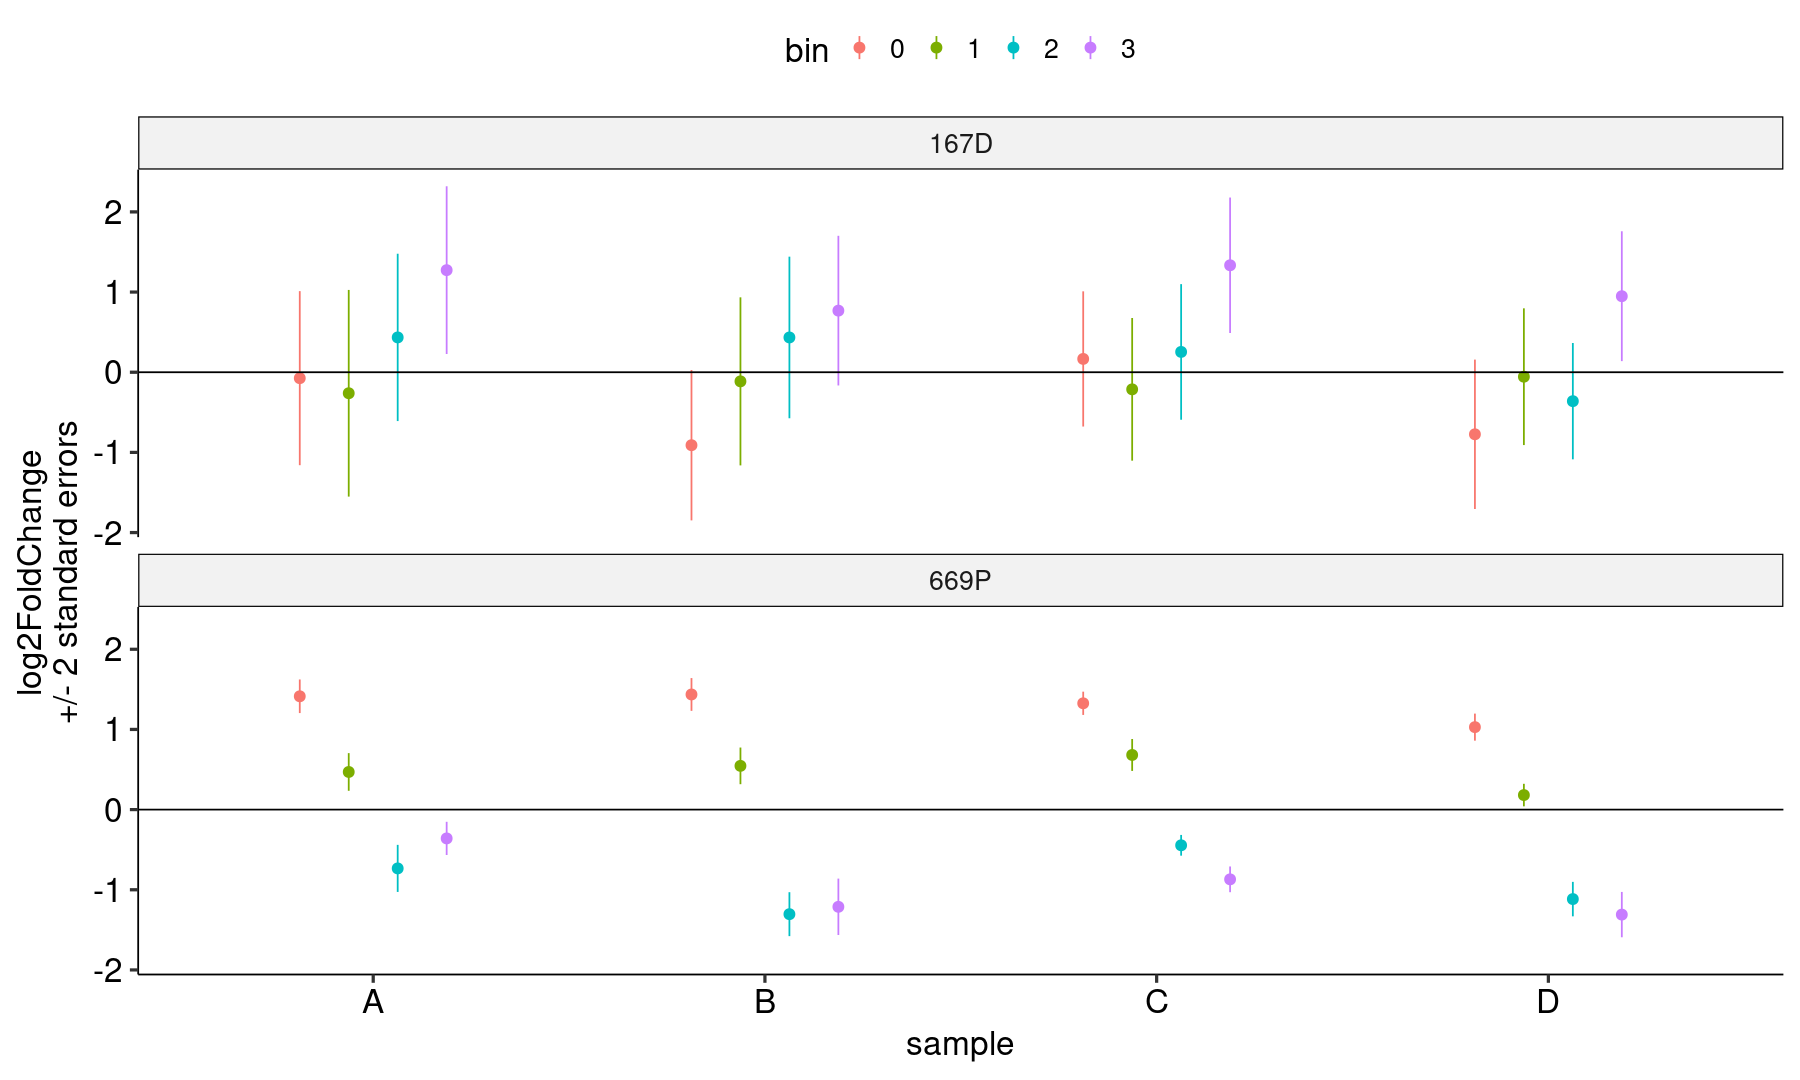

In [71]:
options(repr.plot.width = 15, repr.plot.height = 9)
sumstats_bin %>%
    filter(paste0(pos, aa) %in% c("167D", "669P")) %>%
    mutate(bin = as.factor(bin)) %>%
    ggplot() +
        geom_pointrange(aes(x = sample, y = estimate,
                            ymin = estimate - 2*std.error,
                            ymax = estimate + 2*std.error, color = bin),
                        position = position_dodge(width = 0.5)) +
        theme_pubr(base_size = 20) +
        geom_hline(yintercept = 0) +
        ylab("log2FoldChange\n+/- 2 standard errors") +
        facet_wrap(~paste0(pos, aa), ncol = 1)

In [5]:
sumstats %>% write_tsv("../sumstats/TYK2-VAMP/run1/tyk2-vampseq-slope.sumstats.tsv")
sumstats_bin %>% write_tsv("../sumstats/TYK2-VAMP/run1/tyk2-vampseq-bin.sumstats.tsv")

### Condition Comparisons <a name="part4"></a>

Considering the slope analysis, we can evaluate the correlation between scores from each condition set (AB, C, and D):

In [15]:
sumstats_wide_z <- sumstats %>%
    select(source, statistic, pos, aa) %>%
    separate(source, c("chunk", "condition"), sep = "-") %>%
    pivot_wider(names_from = condition, values_from = statistic) %>%
    mutate(group = if_else(aa == "*", "Stop", "NonStop")) %>%
    select(-pos, -aa)

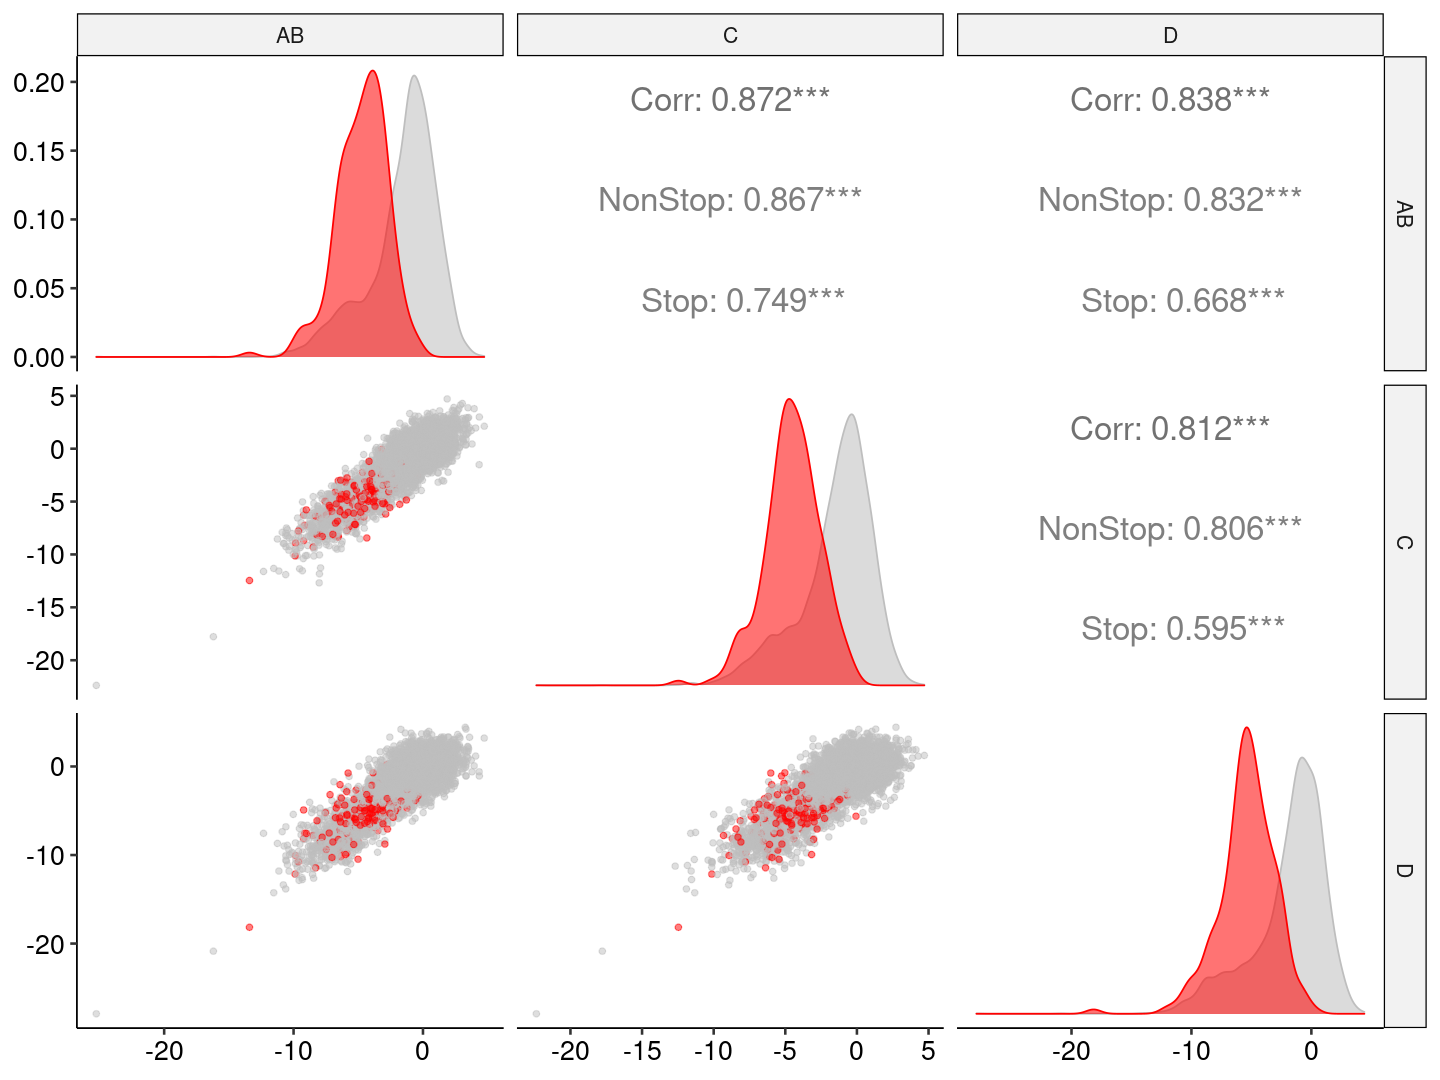

In [22]:
options(repr.plot.width = 12, repr.plot.height = 9)
ggpairs(sumstats_wide_z, columns = 2:4,
        upper = list(continuous =wrap("cor", size = 7)),
        lower = list(continuous = wrap("points", alpha = 0.5)),
        aes(colour = group, fill = group, alpha = 0.4)) +
    theme_pubr(base_size = 16) +
    scale_color_manual(values = c("Stop" = "red", "NonStop" = "gray")) +
    scale_fill_manual(values = c("Stop" = "red", "NonStop" = "gray"))

Stops are less correlated since they are more consistently negative and thus have a smaller range. We can examine the significance boundaries for each of the three pairs more closely:

In [59]:
compare_z <- function(df, conds){
    
    df_wide <- df %>%
        select(source, statistic, p.adj, pos, aa) %>%
        separate(source, c("chunk", "condition"), sep = "-") %>%
        filter(condition %in% conds) %>%
        pivot_wider(names_from = condition, values_from = c(statistic, p.adj)) %>%
        mutate(`Stop Group` = if_else(aa == "*", "Stop", "NonStop"),
               "FDR < 0.01" = case_when( .[[6]]< 0.01 & .[[7]] > 0.01 ~ paste0(conds[1], " Only"),
                               .[[6]] > 0.01 & .[[7]] < 0.01 ~ paste0(conds[2], " Only"),
                               .[[6]] < 0.01 & .[[7]] < 0.01 ~ "Both",
                               TRUE ~ "Neither"))
    
    colors <- c("black", "gray", "red", "purple")
    names(colors) <- c("Both", "Neither",
                       paste0(conds[1], " Only"),
                       paste0(conds[2], " Only"))
    
    scatter_categ <- ggplot(df_wide,
                            aes(x = .data[[paste0("statistic_", conds[1])]],
                                y = .data[[paste0("statistic_", conds[2])]],
                                color = `FDR < 0.01`)) +
        geom_point(size = 3, pch = 21) +
        theme_pubr(base_size = 20) +
        geom_abline(slope = 1, intercept = 0) +
        geom_hline(yintercept = 0) +
        geom_vline(xintercept = 0) +
        theme(legend.pos = "left") +
        xlab(paste0("Z-Statistic, Condition ", conds[1])) +
        ylab(paste0("Z-Statistic, Condition ", conds[2])) +
        scale_color_manual(values = colors)
    
    return(scatter_categ)
}

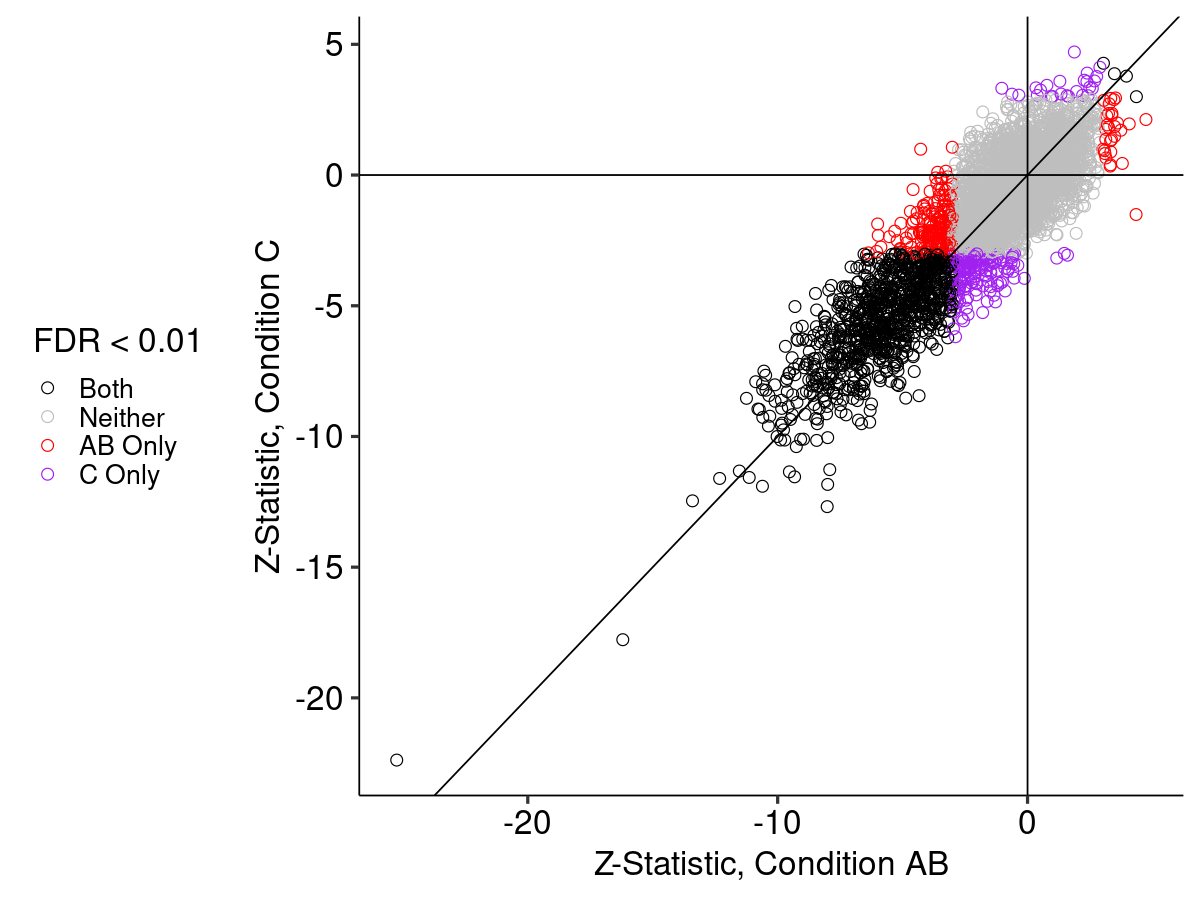

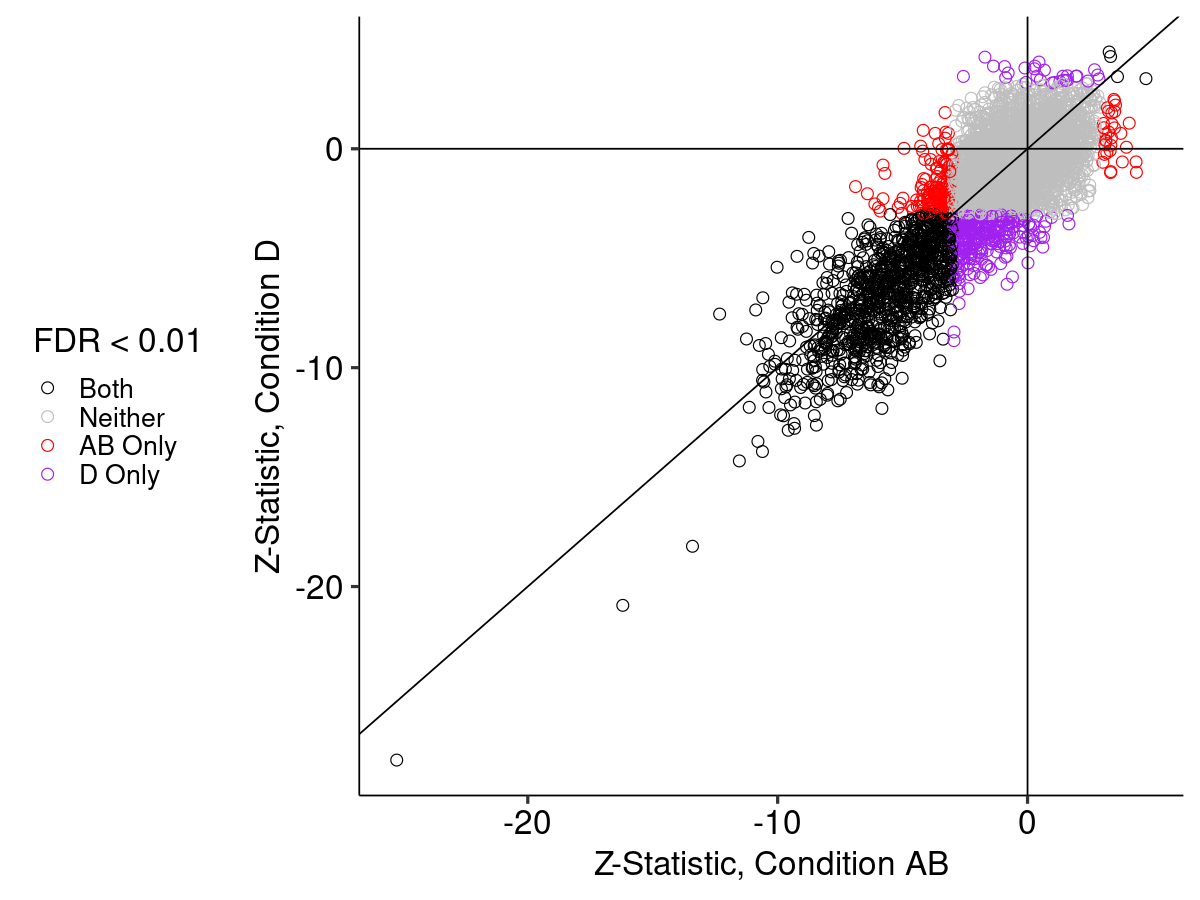

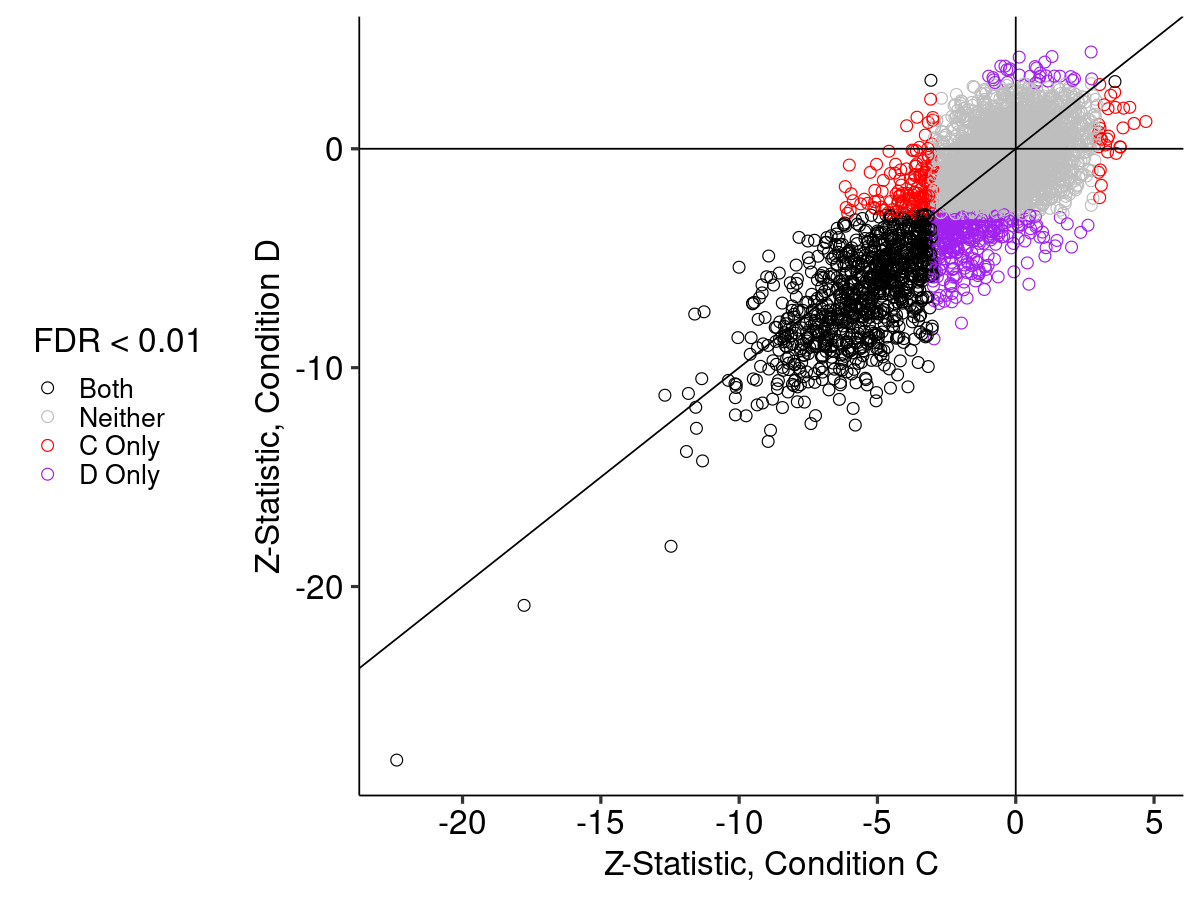

In [61]:
options(repr.plot.width = 10, repr.plot.height = 7.5)
compare_z(sumstats, c("AB", "C"))
compare_z(sumstats, c("AB", "D"))
compare_z(sumstats, c("C", "D"))

### Effect of Barcode Map Reduction <a name="part5"></a>

If we separate the barcode map into A and B subcomponents, but leave the rest of the pipeline the same, we get the following numbers of entries in the barcode maps for each chunk:

In [6]:
sizes <- tibble("chunk" = c(10, 14, 3),
               "total" = c(1509803, 2288729, 1073748),
                "A" =  c(647418, 1006554, 360452),
                "B" = c(862385, 1282175, 713296))

sizes %>% kable("markdown")



| chunk|   total|       A|       B|
|-----:|-------:|-------:|-------:|
|    10| 1509803|  647418|  862385|
|    14| 2288729| 1006554| 1282175|
|     3| 1073748|  360452|  713296|

To determine the effects of only integrating A or B but not both, we generated the barcode map using either only A or only B but with all other filters (e.g. across sequencing replicates) intact. From here, we can extract the median number of barcodes per variant under each map and in each condition:

In [7]:
mapped_counts_A <- vroom("../pipeline/OCNT-VAMPLIB-1-assay-run1/tyk2-vamp-mini-form-A.mapped-counts.tsv",
                          col_names = c("sample", "barcode", "count", "lib", "chunk", 
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon",
                                        "dox", "chunkID", "condition", "condition_conc","clone"))  %>%
    mutate(condition = as.factor(paste0(condition, condition_conc)),
           mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT")) %>%
    group_by(sample) %>%
    mutate(stop_counts = sum(count[which(mut_aa == "*")]))

mapped_counts_B <- vroom("../pipeline/OCNT-VAMPLIB-1-assay-run1/tyk2-vamp-mini-form-B.mapped-counts.tsv",
                          col_names = c("sample", "barcode",  "count", "lib", "chunk", 
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon",
                                        "dox", "chunkID", "condition", "condition_conc","clone"))  %>%
    mutate(condition = as.factor(paste0(condition, condition_conc)),
           mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT")) %>%
    group_by(sample) %>%
    mutate(stop_counts = sum(count[which(mut_aa == "*")]))

Rows: 527722 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, condition
dbl (4): count, chunk, pos, condition_conc
lgl (3): dox, chunkID, clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1108890 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, condition
dbl (4): count, chunk, pos, condition_conc
lgl (3): dox, chunkID, clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
plot_bcs_per_var <- function(mc_file){
    
    bc_counts_aa <- mc_file %>%
        ungroup() %>%
        filter(mut_aa != "WT", chunk != 15) %>%
        select(sample,mut_aa, pos, chunk, barcode) %>%
        mutate(sample = str_sub(sample, 1, 1)) %>%
        distinct() %>%
        group_by(sample,mut_aa, pos, chunk) %>%
        count()

    the_table <- bc_counts_aa %>%
        ungroup() %>% 
        group_by(sample = str_sub(sample, 1, 1), chunk) %>%
        summarize(med = median(n)) %>%
        pivot_wider(names_from = chunk, values_from = med)

    return(the_table)
    
}

In [13]:
sub_a_result <- plot_bcs_per_var(mapped_counts_A)
sub_b_result <- plot_bcs_per_var(mapped_counts_B)

names(sub_a_result)[2:4] <- str_c(names(sub_a_result)[2:4], "A")
names(sub_b_result)[2:4] <- str_c(names(sub_b_result)[2:4], "B")

sub_result <- inner_join(sub_a_result, sub_b_result)

orig_result <- plot_bcs_per_var(mapped_counts)

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.
Joining with `by = join_by(sample)`
`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


In [28]:
inner_join(sub_result,
           orig_result %>% rename("3AB" = "3",
                                  "10AB" = "10",
                                  "14AB" = "14"), by = "sample") %>%
    relocate(sample, str_c(3, c("A", "B", "AB")),
             str_c(10, c("A", "B", "AB")),
             str_c(14, c("A", "B", "AB"))) %>%
    kable("markdown", digits = 0)



|sample | 3A| 3B| 3AB| 10A| 10B| 10AB| 14A| 14B| 14AB|
|:------|--:|--:|---:|---:|---:|----:|---:|---:|----:|
|A      |  9|  8|  17|   7|  29|   36|   9|  35|   43|
|B      |  6|  8|  15|   7|  15|   22|   9|  16|   25|
|C      | 19| 10|  29|  10|  88|   98|  11|  64|   75|
|D      | 14| 14|  29|  13|  45|   58|  15|  31|   46|

The above table indicates that, for many samples, the number of barcodes detected in a sample from a given A or B pool is more imbalanced than would be expected given the contribution of each pool to the barcode map. To evaluate the extent to which this propagates to the final summary statistics, we run the model using either A or B separately, and compare it to the original model where we considered the union of A and B. The most useful way to summarize the result is via the standard errors:

In [43]:
sim_data <-  dir_ls(path = "../sumstats/TYK2-VAMP/run1-bc-split/", regexp = "tyk2-.*combined.sumstats.tsv") %>%
    map_dfr(read_tsv, col_types = c("ncccnnnnnc"), .id = "group") %>%
    filter(grepl("mut_aa",term), pos != 1188) %>%
    separate(term, c("condition", "aa"), ":") %>% 
    mutate(group = gsub("../sumstats/TYK2-VAMP/run1-bc-split/tyk2-vamp-mini-|-combined.sumstats.tsv", "", group),
           estimate = estimate / log(2),
           std.error = std.error / log(2),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa),
           condition = gsub("condition", "", condition),
           condition = if_else(condition == "D101", "D100", condition),
           sample = str_sub(condition, start = 1, end = 1),
           bin = as.numeric(str_sub(condition, start = 2, end = 4))) %>%
    select(-clone, -dispersion, -version) %>%
    separate(group, c("bc_pool", "chunk"), "_") %>%
    separate(chunk, c("chunk", "sample_group"), "-")

In [44]:
sumstats_union <- read_tsv("../sumstats/TYK2-VAMP/run1/tyk2-vampseq-bin.sumstats.tsv")

agg_sumstats <- bind_rows(sumstats_union %>% mutate(bc_pool = "Full",
                                  chunk = as.character(chunk),
                                  bin = (bin + 1)*25),
                          sim_data %>% select(-sample_group)) %>%
    filter(chunk != "15")

Rows: 74384 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): condition, aa, sample
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, bin

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


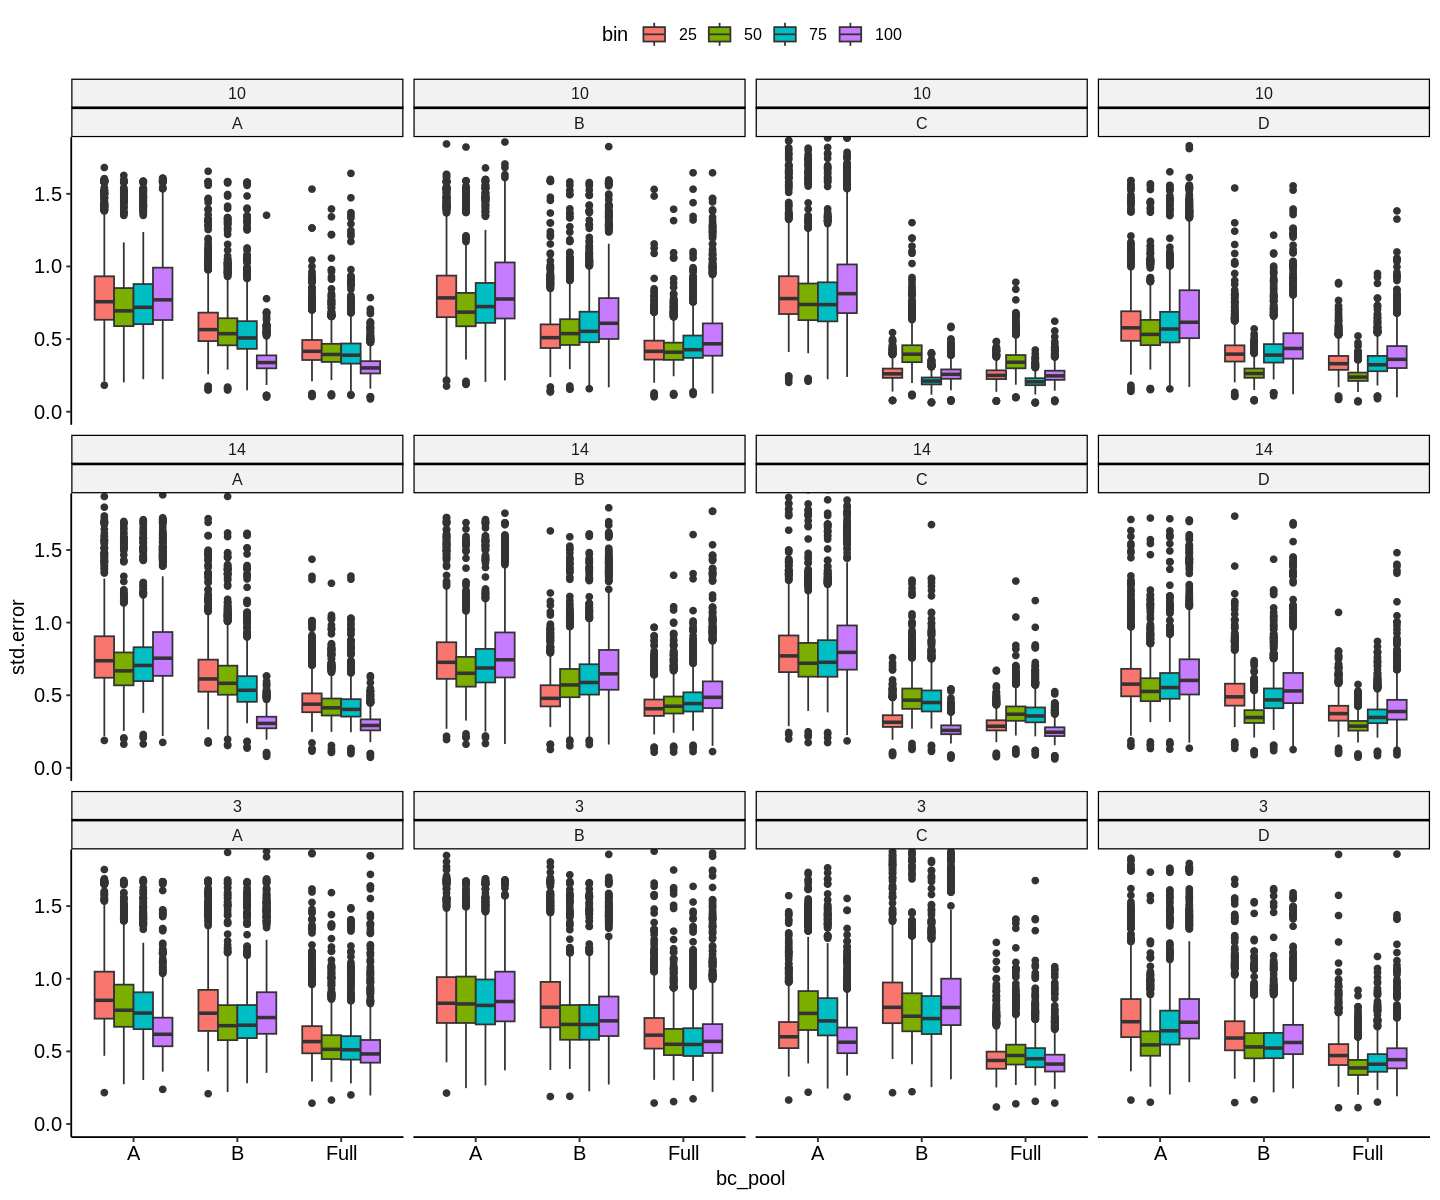

In [47]:
options(repr.plot.width = 12, repr.plot.height = 10)
ggplot(agg_sumstats %>% mutate(bin = as.factor(bin))) +
        geom_boxplot(aes(x = bc_pool, y = std.error, fill = bin), position = position_dodge()) +
        facet_wrap(~chunk + sample) +
        theme_pubr() +
        coord_cartesian(ylim = c(0,1.8))

In all cases, both A and B have higher standard errors than Full due to having fewer barcodes. However, the standard error increase is generally much larger when only pool A is used. This is consistent with (generally) a much larger number of detected barcodes originating from pool B compared to pool A. This is true despite the fact that both pool A and pool B contained similar numbers of barcodes during barcode mapping. Thus, taken together, this suggests some imbalance when pooling A and B for the assay.